Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


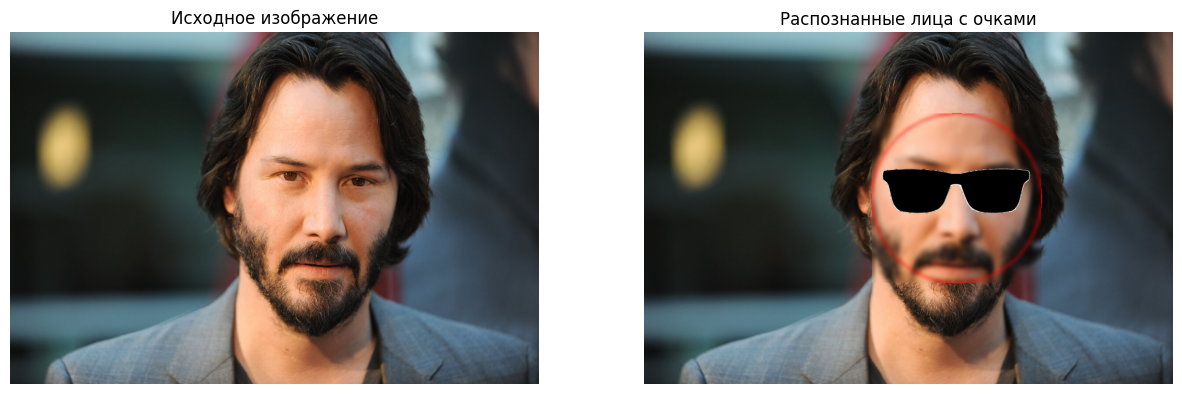

In [ ]:
import cv2
import gdown
from matplotlib import pyplot as plt
# Команда обеспечивает вывод графиков в Google Colaboratory
%matplotlib inline

gdown.download('https://avatars.dzeninfra.ru/get-zen_doc/96748/pub_5ae9de74dd248401aaf97108_5ae9f2744826773d1f54e894/scale_1200', None, quiet=True)

from google.colab import drive
drive.mount('/content/drive')

# изображение с очками без фона
img_glasses = cv2.imread('/content/drive/MyDrive/krutye_ochki_risunok_22.png', cv2.IMREAD_UNCHANGED)

# Загрузка изображения
img = cv2.imread('./scale_1200')

img2 = img.copy() # копирование переменной

# загрузка каскада Хаара
classifier = cv2.CascadeClassifier(cv2.data.haarcascades+ "haarcascade_frontalface_default.xml")

# загрузка каскада Хаара для поиска глаз
classifier_eye = cv2.CascadeClassifier(cv2.data.haarcascades+ "haarcascade_eye.xml")

# выполнение распознавания лиц
bboxes = classifier.detectMultiScale(img, scaleFactor=2, minNeighbors=3, minSize=(50, 50))

# формирование прямоугольника вокруг каждого обнаруженного лица
for box in bboxes:
    # формирование координат лица
    x, y, width, height = box
    center_face = (int(x + width / 2), int(y + height / 2))
    axes = (int(width / 2), int(height / 2))
    # рисование овала вокруг лица
    cv2.ellipse(img2, center_face, axes, 0, 0, 360, (0, 0, 255), 2)

    # извлечение области с лицом
    face = img2[y:y + height, x:x + width]

    # Нахождение глаз на лице
    eyes = classifier_eye.detectMultiScale(face)

    # Если обнаружены оба глаза, находим точку между ними
    if len(eyes) >= 2:
        # Сортировка глаз по координате x
        eyes = sorted(eyes, key=lambda x: x[0])
        # Вычисление координат точки между глазами
        eye1_x, eye1_y, eye1_w, eye1_h = eyes[0]
        eye2_x, eye2_y, eye2_w, eye2_h = eyes[1]
        eye_center_x = (eye1_x + eye1_w // 2 + eye2_x + eye2_w // 2) // 2
        eye_center_y = (eye1_y + eye1_h // 2 + eye2_y + eye2_h // 2) // 2

        # Применение гауссовского размытия к области лица
        blurred_face = cv2.GaussianBlur(face, (25, 25), 0)

        # Замена области лица на размытую версию
        img2[y:y+height, x:x+width] = blurred_face

        # Коэффициент увеличения размера очков
        scale_factor = 1

        # Размеры и положение очков
        glasses_width = int(scale_factor * 4 * abs(eye1_x - eye2_x))
        glasses_height = int(scale_factor * glasses_width * img_glasses.shape[0] / img_glasses.shape[1])

        # Изменение размера очков
        glasses_resized = cv2.resize(img_glasses, (glasses_width, glasses_height))
        # Положение очков
        glasses_x = eye_center_x - glasses_width // 2
        glasses_y = (eye_center_y - glasses_height // 2) + 30

        # Наложение очков на изображение
        for i in range(glasses_resized.shape[0]):
            for j in range(glasses_resized.shape[1]):
                if glasses_resized[i, j, 3] != 0:
                    img2[y + glasses_y + i, x + glasses_x + j, :] = glasses_resized[i, j, :-1]



# Отображение изображений
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Исходное изображение')
ax1.axis('off')

ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax2.set_title('Распознанные лица с очками')
ax2.axis('off')

plt.show()